<a href="https://colab.research.google.com/github/simonperrott/stockatron/blob/master/stockatron_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
!pip install yfinance

In [136]:
import yfinance as yt
import numpy as np
import pandas as pd
from matplotlib import pyplot

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15
pd.options.display.max_columns = 20

pyplot.style.use("dark_background")

In [137]:
# Fn to create the price change after X numDaysForward.
def create_change_column(df:pd.DataFrame, threshold:float, numDaysForward = -5):
  df['CloseAfterXDays'] = df['Close'].shift(numDaysForward, axis=0)
  change_series = 100* (df['CloseAfterXDays'] - df['Open'])/df['Open']
  return change_series

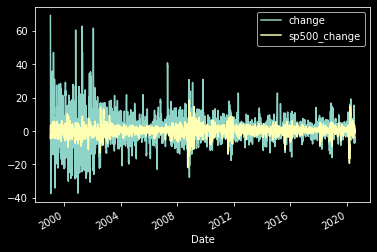

            Open  Close    Volume  CloseAfterXDays  change  sp500_change
Date                                                                    
1999-01-04 54.61  59.16  39292200            92.31   69.03          2.82
1999-01-05 54.78  62.25  62873200            81.69   49.12          0.93
1999-01-06 68.19  69.00  36176600            74.00    8.52         -0.83
1999-01-07 68.56  79.44  47274600            69.00    0.64         -4.73
1999-01-08 92.12  80.12  66662200            70.19  -23.81         -2.08


In [138]:
amzn = yt.Ticker('AMZN')
start_date = '1999-01-01'
df = amzn.history(start=start_date)
df.drop(['Dividends', 'Stock Splits', 'High', 'Low'], axis=1, inplace=True)
df['change'] = create_change_column(df, 5.0)

# S&P500
gspc = yt.Ticker('^GSPC')
df_gspc = gspc.history(start=start_date)
df['sp500_change'] = create_change_column(df_gspc, 5.0)

df[['change', 'sp500_change']].plot()
pyplot.legend(loc="upper right")
pyplot.show()

print(df.head(5))

In [139]:
# Add output y labels
def create_labels(df:pd.DataFrame, threshold:float):

  # 0 HOLD => -ve threshold < % Change < +ve threshold
  # 1 BUY => % Change > +ve threshold
  # -1 SELL => % Change < -ve threshold
  df['label'] = df['change'].apply(lambda x: 1 if x > threshold else -1 if x < -1*threshold else 0)

  scaler = StandardScaler() # or MinMaxScaler(feature_range=(-1, 1))
  df['change'] = scaler.fit_transform(df[['change']])
  df.dropna(inplace=True)
  return df

In [140]:
df = create_labels(df, 5.0)
print(df.tail(5))

              Open   Close   Volume  CloseAfterXDays  change  sp500_change  \
Date                                                                         
2020-07-16 2971.06 2999.90  6394200          2986.55   -0.02          0.85   
2020-07-17 3009.00 2961.97  4761300          3008.91   -0.09         -0.27   
2020-07-20 3000.20 3196.84  7598200          3055.21    0.14          0.47   
2020-07-21 3232.49 3138.29  6135000          3000.33   -1.00         -1.53   
2020-07-22 3125.00 3099.91  4104200          3022.04   -0.50         -0.21   

            label  
Date               
2020-07-16      0  
2020-07-17      0  
2020-07-20      0  
2020-07-21     -1  
2020-07-22      0  


In [141]:
# Scale input features
from sklearn.preprocessing import StandardScaler

def scale_features(df:pd.DataFrame, feature_column_names):
  
  df[['change', 'sp500_change']].hist()
  pyplot.show()
  scaler = StandardScaler() # Using Standardization as ditribution is Gaussian (alternative -> MinMaxScaler(feature_range=(-1, 1))
  for col in feature_column_names:
    df[col] = scaler.fit_transform(df[[col]])

  df.dropna(inplace=True)
  return df

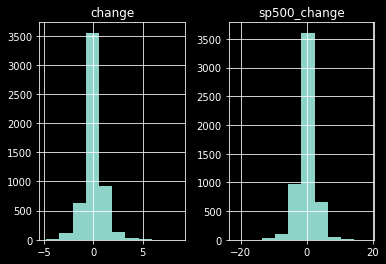

            change  sp500_change  label
Date                                   
2020-07-16   -0.02          0.27      0
2020-07-17   -0.09         -0.15      0
2020-07-20    0.14          0.12      0
2020-07-21   -1.00         -0.62     -1
2020-07-22   -0.50         -0.13      0


In [142]:
features = ['change', 'sp500_change']

df = scale_features(df, features)

# select subset of columns with features for the timeseries and label
features.append('label')
df = df[features]
print(df.tail(5))

In [143]:
from pandas import DataFrame
from pandas import concat

def dataframe_to_supervised(df, input_cols, pred_col, n_timesteps=1, dropnan=True):
	"""
	Time series -> LSTM supervised learning dataset.
	Arguments:
		data: Sequence of observations as a NumPy array.
		input_cols: list of strings identifying the input feature columns to use in shifting
		n_timesteps: Number of lag observations as input (X).
		pred_col: the name of the column we want to predict
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_timesteps, 0, -1):
		cols.append(df[input_cols].shift(i))
		names += [f'{c}(t-{i})' for c in input_cols]

	# add pred_col
	cols.append(df[pred_col])
	names.append(pred_col)

	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [145]:
# Baseline 1st Model uses:
# batches of timeseries of prices going back 20 days
num_time_steps = 20
df_price_ts = dataframe_to_supervised(df, ['change', 'sp500_change'], 'label', num_time_steps, dropnan = False)
prediction_X = df_price_ts.values[-1, :-1]
# now drop NaNs created during transformation to a Timeseries
df_price_ts.dropna(inplace=True)
print(df_price_ts.shape)
df_price_ts.tail(2)

(40,)
(5403, 41)


,change(t-20),sp500_change(t-20),change(t-19),sp500_change(t-19),change(t-18),sp500_change(t-18),change(t-17),sp500_change(t-17),change(t-16),sp500_change(t-16),...,sp500_change(t-5),change(t-4),sp500_change(t-4),change(t-3),sp500_change(t-3),change(t-2),sp500_change(t-2),change(t-1),sp500_change(t-1),label
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-21,-0.11,-0.55,0.06,-0.51,0.36,-0.03,0.61,0.97,1.19,1.24,...,1.33,-0.01,0.53,-0.02,0.27,-0.09,-0.15,0.14,0.12,-1
2020-07-22,0.06,-0.51,0.36,-0.03,0.61,0.97,1.19,1.24,1.37,1.52,...,0.53,-0.02,0.27,-0.09,-0.15,0.14,0.12,-1.00,-0.62,0


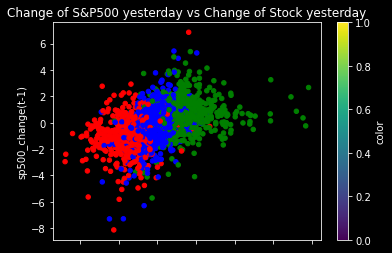

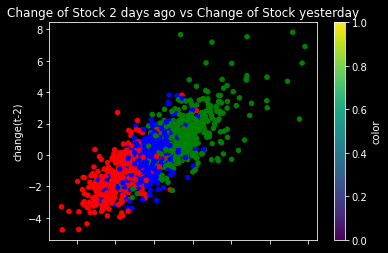

In [146]:
# Plot the data classes using only the previous day's change & sp500 change
df_price_ts['color'] = df_price_ts['label'].apply(lambda x: 'blue' if x==0 else 'red' if x==-1 else 'green')

df_price_ts.plot.scatter(x='change(t-1)', y='sp500_change(t-1)', c='color')
pyplot.title('Change of S&P500 yesterday vs Change of Stock yesterday')
pyplot.show()

df_price_ts.plot.scatter(x='change(t-1)', y='change(t-2)', c='color')
pyplot.title('Change of Stock 2 days ago vs Change of Stock yesterday')
pyplot.show()
# Note a Linear model could not separate these to classify correctly
df_price_ts.drop(['color'] , axis=1, inplace=True)

In [147]:
# Choose Training data (avoiding data leak by training set having no data points in future of test set)
train = df_price_ts.loc['2000' :'2017']

In [148]:
# Explore balance of classes in Training set
label_groupings = train['label'].value_counts()
print(label_groupings)

 0    2881
 1     947
-1     700
Name: label, dtype: int64


In [149]:
# Balance classes in Training set by Down sampling randomly.
# This is important for accuracy as I'm more interested in accurately predicting cases -1 and +1 rather than 0.
from sklearn.utils import resample

min_label_count = label_groupings.min()
df_list = []
# Separate by label
for label in label_groupings.index:
  df_for_label = train[train.label == label]
  df_list.append(
      resample(  
          df_for_label, 
          replace = False,    # sample without replacement
          n_samples = min_label_count     # to match minority class
          )) 

train_balanced = pd.concat(df_list)

print(train_balanced.shape) 
# Display new class counts
train_balanced.label.value_counts()

(2100, 41)


 1    700
-1    700
 0    700
Name: label, dtype: int64

In [152]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

training_set = train_balanced.values

train_X, train_y = training_set[:, :-1], training_set[:, -1]

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_y)
train_y_encoded = encoder.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
train_y_dummy = np_utils.to_categorical(train_y_encoded)

# Validation data 2018 - 2019
val = df_price_ts.loc['2018' :'2020'].values
val_X, val_y = val[:, :-1], val[:, -1]
val_y_encoded = encoder.transform(val_y)
val_y_dummy = np_utils.to_categorical(val_y_encoded)

# Test data 2020
test = df_price_ts.loc['2020'].values
test_X, test_y = test[:, :-1], test[:, -1]
test_y_encoded = encoder.transform(test_y)
test_y_dummy = np_utils.to_categorical(test_y_encoded)

n_features = 2

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape(train_X.shape[0], num_time_steps, n_features)
val_X = val_X.reshape(val_X.shape[0], num_time_steps, n_features)
test_X = test_X.reshape(test_X.shape[0], num_time_steps, n_features)

print(f'Train X has shape: {train_X.shape} & Train y has shape: {train_y_dummy.shape}')
print(f'Validation X has shape: {val_X.shape} & Validation y has shape: {val_y_dummy.shape}')
print(f'Test X has shape: {test_X.shape} & Test y has shape: {test_y_dummy.shape}')

Train X has shape: (2100, 20, 2) & Train y has shape: (2100, 3)
Validation X has shape: (643, 20, 2) & Validation y has shape: (643, 3)
Test X has shape: (140, 20, 2) & Test y has shape: (140, 3)


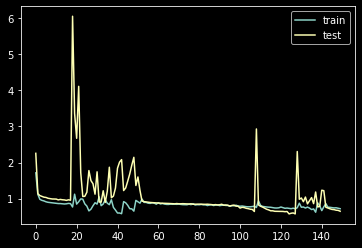

140/140 [==============================] - 0s 177us/step
Accuracy: 66.43


In [153]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout

# design network 
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(num_time_steps, n_features), dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
# fit network
history = model.fit(train_X, train_y_dummy, epochs=150, batch_size=20, validation_data=(val_X, val_y_dummy), verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# evaluate model against an unseen test set
_, accuracy = model.evaluate(test_X, test_y_dummy)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# Questions to answer...
# 1. Why is Test loss smaller than Training loss?
# 2. Why is Test loss increasing with iterations?

In [ ]:
# TODO Experiements: 
# Try with a larger timeseries (the past 30 days)
# Try stateful 5
# Add regularizer to bias & weights

In [157]:
# Predict the change over the next 5 days
x = prediction_X.reshape(1, num_time_steps, n_features)
next5days_class = model.predict_classes(x)
print(f'Stock expected to shift: {next5days_class} within next 5 trading days')

Stock expected to shift: [1] within next 5 trading days


In [ ]:
# Save the model
